In [1]:
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from utils.general_utils import load_data_old, get_cat_feature_names
from utils.model_extensions_utils import FocalLossObjective
from utils.plot_utils import Evaluation
# from utils.fe_utils import get_growth_features
from explainerdashboard import ClassifierExplainer, ExplainerDashboard, InlineExplainer
import matplotlib.pyplot as plt
import shap
from utils.fe_utils import get_growth_features



The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
def process_df(X_temp):
    # - remove zero variance features
    # cols_to_drop = [col for col in X_temp.select_dtypes(include=np.number).columns if np.std(X_temp[col]) == 0]
    # X_temp = X_temp.drop(cols_to_drop, axis=1)
    tech_cols = ['maven', 'generic', 'docker', 'npm', 'pypi', 'gradle', 'nuget']
    usage_cols = tech_cols + ['artifacts_count', 'artifacts_size', 'binaries_count', 'binaries_size', 'items_count',
                              'number_of_permissions', 'internal_groups', 'number_of_users', 'n_env', 'n_tech',
                              'n_repos']
    X_temp['n_tech'] = (X_temp[tech_cols] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.1'] = (X_temp[[col + '.1' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.2'] = (X_temp[[col + '.2' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.3'] = (X_temp[[col + '.3' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_tech.4'] = (X_temp[[col + '.4' for col in tech_cols]] != 0).astype(int).sum(axis=1)
    X_temp['n_repos'] = (X_temp[tech_cols]).sum(axis=1)
    X_temp['n_repos.1'] = (X_temp[[col + '.1' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.2'] = (X_temp[[col + '.2' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.3'] = (X_temp[[col + '.3' for col in tech_cols]]).sum(axis=1)
    X_temp['n_repos.4'] = (X_temp[[col + '.4' for col in tech_cols]]).sum(axis=1)
    # X_temp['leading_tech'] = list(X_temp[tech_cols].idxmax(axis=1))
    # X_temp.loc[X_temp['leading_tech'].isin(['npm', 'gradle', 'pypi']), 'leading_tech'] = 'else'

    # - get trends features
    for col in usage_cols:
        growth_feature_monthly, growth_feature_quarter, df_fg = get_growth_features(col, X_temp.copy())
        X_temp[col + '_monthly_growth'] = growth_feature_monthly
        X_temp[col + '_quarter_growth'] = growth_feature_quarter


    # - transform to category
    cat_features = get_cat_feature_names(X_temp)
    for col in cat_features:
        X_temp[col] = X_temp[col].astype('category')

    # - drop usage features from the periods before the relevant-date
    cols_to_drop = [col for col in X_temp.columns if '.1' in col or '.2' in col or '.3' in col or '.4' in col]
    X_temp = X_temp.drop(cols_to_drop, axis=1)
    X_temp['artifacts/binaries_size'] = np.where(X_temp['binaries_size'] == 0, 0, X_temp['artifacts_size'] / X_temp['binaries_size'])
    X_temp['artifacts/binaries_count'] = np.where(X_temp['binaries_count'] == 0, 0, X_temp['artifacts_count'] / X_temp['binaries_count'])
    X_temp = X_temp.drop(['total_employees_with_details', 'days_from_contact_added', 'territory', 'industry_group',
                          'total_employees_range'], axis=1)
    return X_temp

In [3]:
consolidate_opps = True
df = load_data_old('fit.sql')

In [4]:
df

,account_id,relevant_date,class,territory,account_id.1,relevant_date.1,period_range,artifacts_count,artifacts_size,binaries_count,...,n_ent_mentioned_sessions,n_competitor_mentioned_sessions,n_xray_mentioned_sessions,n_replys,n_sent,n_calls,n_task_xray,replys_to_sent,days_since_reply,days_since_sent
0,0011r00001iACCU,2018-08-25 00:00:00,0,EMEA,0011r00001iACCU,2018-08-25 00:00:00,3 Months,1289272,14066,638194,...,0,0,0,0,0,0,0,-1.000000,1000,1000
1,0011r00001iACCU,2019-08-09 00:00:00,0,EMEA,0011r00001iACCU,2019-08-09 00:00:00,3 Months,1844459,27343,875317,...,0,0,0,0,1,0,0,0.000000,259,85
2,0011r00001iACCU,2020-08-27 00:00:00,0,EMEA,0011r00001iACCU,2020-08-27 00:00:00,3 Months,515803,35022,397341,...,0,0,1,1,6,0,0,0.166667,9,9
3,0011r00001iACGM,2019-08-30 00:00:00,0,EMEA,0011r00001iACGM,2019-08-30 00:00:00,3 Months,56486,234,48490,...,0,0,0,0,2,0,0,0.000000,1000,57
4,0011r00001iACGM,2020-08-28 00:00:00,0,EMEA,0011r00001iACGM,2020-08-28 00:00:00,3 Months,87529,401,81005,...,0,0,0,0,0,0,0,-1.000000,1000,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,001w000001kgU5v,2018-08-30 00:00:00,0,Americas,001w000001kgU5v,2018-08-30 00:00:00,3 Months,132,0,128,...,0,0,0,0,0,0,0,-1.000000,1000,1000
5694,001w000001kgfaR,2018-10-16 00:00:00,0,EMEA,001w000001kgfaR,2018-10-16 00:00:00,3 Months,24491,623,14349,...,0,0,0,0,0,0,0,-1.000000,1000,1000
5695,001w000001kgfaR,2019-10-15 00:00:00,0,EMEA,001w000001kgfaR,2019-10-15 00:00:00,3 Months,36144,872,22216,...,0,0,0,0,0,0,0,-1.000000,1000,152
5696,001w000001kgfaR,2020-09-19 00:00:00,0,EMEA,001w000001kgfaR,2020-09-19 00:00:00,3 Months,61167,1073,37468,...,0,0,0,0,0,0,0,-1.000000,1000,180


In [5]:
if consolidate_opps:
    has_won = df.groupby('account_id', as_index=False).sum('class').loc[:, ['account_id', 'class']]
    has_won['has_won'] = has_won['class'].apply(lambda x: True if x > 0 else False)
    has_won.drop('class', axis=1, inplace=True)
    new_df = df.merge(has_won, on='account_id')
    df_did_win, df_did_not_win = new_df[new_df['has_won']], new_df[~new_df['has_won']]
    df_did_win = df_did_win[df_did_win['class'] == 1].groupby('account_id', as_index=False).min('relevant_date')
    df_did_not_win = df_did_not_win.groupby('account_id').sample(n=1, random_state=2)
    df = pd.concat([df_did_win, df_did_not_win])
    df = df.sample(frac=1, random_state=2).reset_index(drop=True)

In [6]:
cols_to_drop = [col for col in df.columns if 'period_range' in col or 'relevant_date' in col or 'account_id' in col
                or 'class' in col or 'has_won' in col]
X, y = df.drop(cols_to_drop, axis=1).fillna(-1), df['class']
X = process_df(X)

In [7]:
print(len(X.columns))
list(X.columns)

103


['artifacts_count',
 'artifacts_size',
 'binaries_count',
 'binaries_size',
 'items_count',
 'number_of_permissions',
 'internal_groups',
 'number_of_users',
 'n_env',
 'maven',
 'generic',
 'docker',
 'npm',
 'pypi',
 'gradle',
 'nuget',
 'n_contacts',
 'n_active_contracts',
 'is_cotermed',
 'count_ent',
 'count_prox',
 'count_pro',
 'n_security_contacts',
 'n_sessions_last_year',
 'n_cases_last_year',
 'n_xray_sessions_last_year',
 'n_cases_last_3_months',
 'n_poor_cases',
 'engineers',
 'devops_engineers',
 'developers',
 'company_age',
 'n_training',
 'qoe_score',
 'days_from_artifacts_count_change',
 'days_from_artifacts_size_change',
 'days_from_binaries_count_change',
 'days_from_binaries_size_change',
 'days_from_items_count_change',
 'days_from_permissions_change',
 'days_from_internal_groups_change',
 'days_from_users_change',
 'n_jira_cases',
 'unresolved_jira_cases',
 'avg_resolution_days',
 'pricing_views',
 'artifactory_views',
 'xray_views',
 'support_views_views',
 'kno

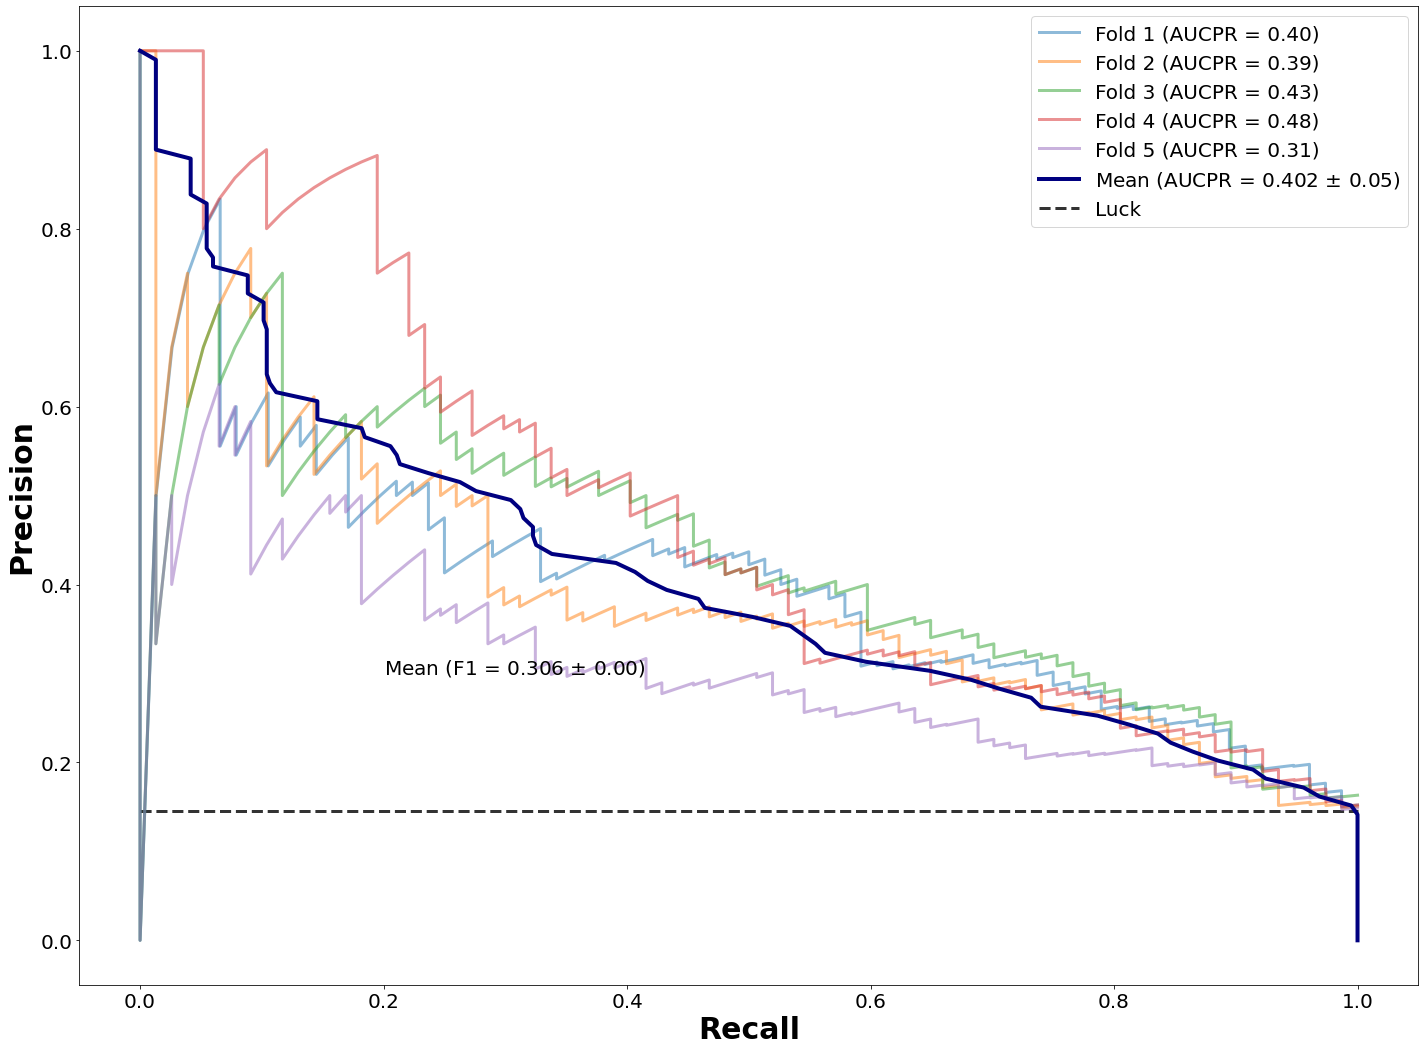

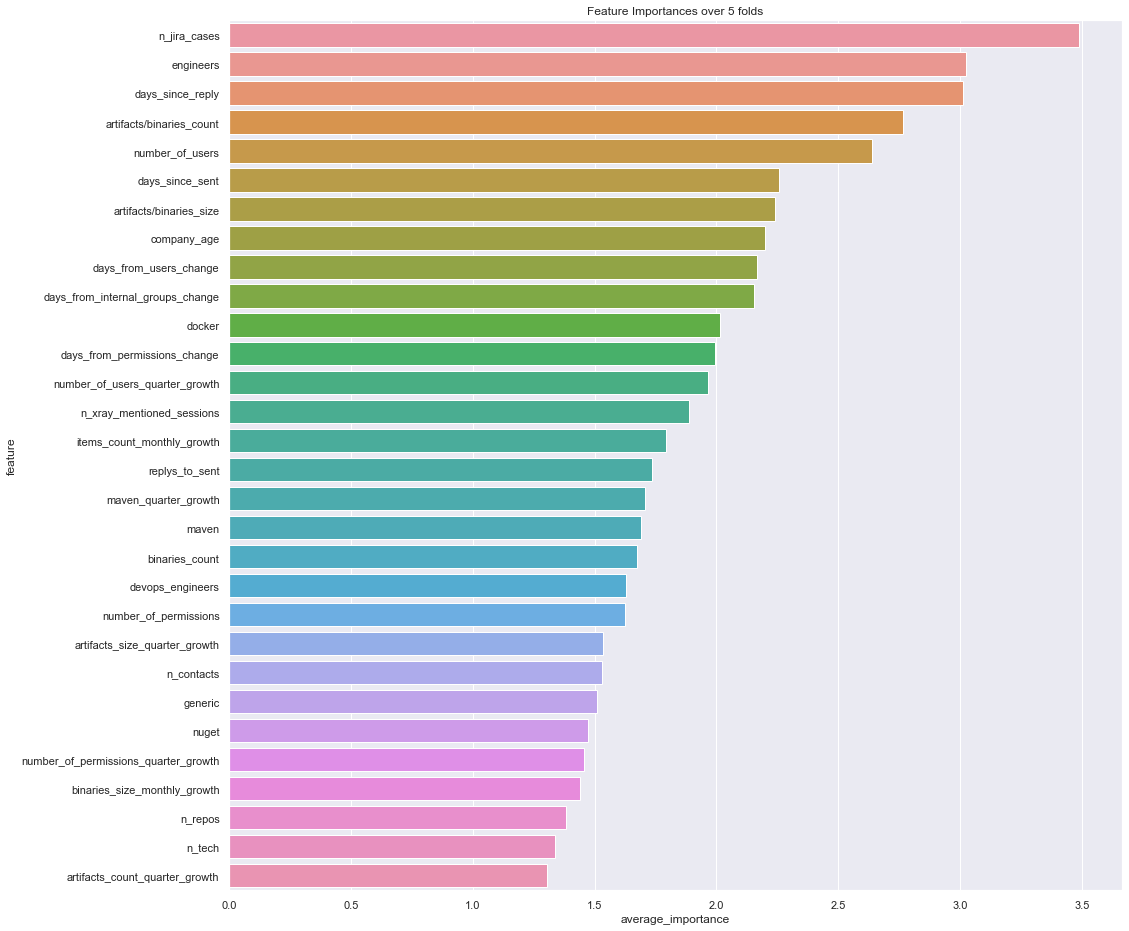

In [8]:
eval = Evaluation()
cbc = CatBoostClassifier(cat_features=get_cat_feature_names(X), auto_class_weights='Balanced', verbose=0,
                         random_state=5, loss_function=FocalLossObjective(), eval_metric="Logloss", bootstrap_type='Bayesian')
lgb = LGBMClassifier(class_weight='balanced', random_state=5)
clfs = [('catboost', cbc), ('lightgbm', lgb)]
stacking = StackingClassifier(estimators=clfs, final_estimator=LogisticRegression(class_weight='balanced'))
feature_importance = eval.plot_cv_precision_recall(clf=cbc, n_folds=5, n_repeats=1, X=X, y=y, stacking=False,
                                              random_state=2, threshold=0.25)
eval.plot_feature_importance(feature_importance.copy(), n_features_to_show=30)

In [9]:
df_for_predict = load_data_old('predict.sql')
cols_to_drop = [col for col in df_for_predict.columns if 'period_range' in col or 'relevant_date' in col or 'account_id' in col
                or 'class' in col or 'has_won' in col]
df_for_predict_clean = df_for_predict.drop(cols_to_drop, axis=1)
df_for_predict_clean = process_df(df_for_predict_clean)
df_for_predict_clean['class_pred_proba'] = cbc.predict_proba(df_for_predict_clean)[:,1]

In [10]:
df_for_predict_clean['class_pred'] = df_for_predict_clean['class_pred_proba'].apply(lambda x: 1 if x >= 0.5 else 0)

In [11]:
np.sum(df_for_predict_clean['class_pred'])

123

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [13]:
cbc.fit(X_train, y_train)

In [14]:
explainer = ClassifierExplainer(cbc, X_test, y_test)

Note: model_output=='probability'. For CatBoostClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [15]:
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


 98%|===================| 521/529 [00:26<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://100.64.0.1:8050
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app 'explainerdashboard.dashboards' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://100.64.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /assets/bootstrap.min.css?m=1632645534.2245514 HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_0_0m1632645533.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_0_0m1632645533.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v0_13_1m1632645534.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /_dash-component-suites/dash/deps/react@16.v2_0_0m1632645533.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_0_0m1632645533.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:37:01] "G

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:15] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [28/Oct/2021 17:45:16] "POST /_dash-update-component HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:24] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:24] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:24] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:26] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/Users/yotaml/Desktop/Projects/pro-prox-model/venv/lib/python3.8/site-packages/dash/dash.py", line 1336, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  F

127.0.0.1 - - [28/Oct/2021 17:45:26] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [28/Oct/2021 17:45:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:45:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Oct/2021 17:45:30] "POST /_dash-update-component HTTP/1.1" 200 -


KeyboardInterrupt: 

In [ ]:
shap_values = shap.TreeExplainer(cbc).shap_values(df_for_predict_clean)
shap.summary_plot(shap_values, df_for_predict_clean, plot_type="bar")
f = plt.figure()
shap.summary_plot(shap_values, df_for_predict_clean)
# f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

In [ ]:
df_for_predict_clean['account_id'] = df_for_predict['account_id']
df_for_predict_clean.loc[df_for_predict_clean['class_pred'] == 1,'account_id'].head(50)

In [ ]:
print("ih")